# Northeastern University Launch Initiative RocketPy Simulations


This notebook contains some simulations of the upcoming November of our rocket. We used RocketPy as a third method of validation. The rocket was modeled to match the OpenRocket and RASAero II inputs.

## Imports

In [1]:
from rocketpy import Environment, SolidMotor, Rocket, Flight
import matplotlib.pyplot as plt


## Setting Up a Simulation

### Creating an Environment for Spaceport America

The `Environment` class is used to define the atmosphere, the winds, and the gravity models.

You can find more information about the `Environment` class in the [Environment Class Usage Docs](https://docs.rocketpy.org/en/latest/notebooks/environment/environment_class_usage.html).


In [3]:
env = Environment(latitude=32.990254, longitude=-106.974998, elevation=1400)

To get weather data from the GFS forecast, available online, we run the following lines.

First, we set tomorrow's date.


In [4]:
import datetime

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

env.set_date(
    (tomorrow.year, tomorrow.month, tomorrow.day, 12)
)  # Hour given in UTC time

Then, we tell env to use a GFS forecast to get the atmospheric conditions for flight.

In [5]:
env.set_atmospheric_model(type="Forecast", file="GFS")

We can see what the weather will look like by calling the info method!



Gravity Details

Acceleration of gravity at surface level:    9.7911 m/s²
Acceleration of gravity at   5.000 km (ASL): 9.7802 m/s²


Launch Site Details

Launch Date: 2024-10-30 12:00:00 UTC
Launch Site Latitude: 32.99025°
Launch Site Longitude: -106.97500°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315468.64 W    3651938.65 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1471.5 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 5.000 km
Forecast Time Period: from 2024-10-29 12:00:00 to 2024-11-14 12:00:00 utc
Forecast Hour Interval: 3 hrs
Forecast Latitude Range: From -90.0° to 90.0°
Forecast Longitude Range: From 0.0° to 359.75°

Surface Atmospheric Conditions

Surface Wind Speed: 217.34 m/s
Surface Wind Direction: 37.34°
Surface Wind Heading: 2.55°
Surface Pressure: 850.75 hPa
Surface Temperature: 282.21 K
Surface Air Density: 1.050 kg/m³
Surface Speed of Sound: 336.77 m/s


Earth Model Details

Earth Radius at Launch s

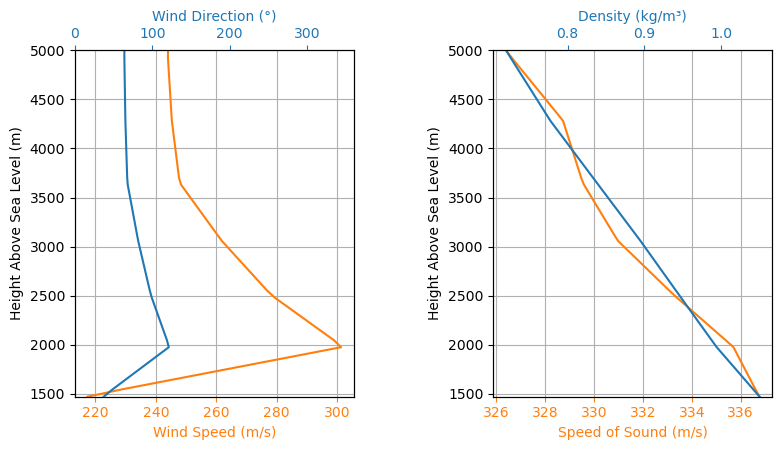

In [6]:
env.max_expected_height = 5000  # adjust the plots to this height
env.info()

### Creating a Motor

A solid rocket motor is used in this case. To create a motor, the SolidMotor class is used and the required arguments are given.

The SolidMotor class requires the user to have a thrust curve ready. This can come either from a .eng file for a commercial motor, such as below, or a .csv file from a static test measurement.

Besides the thrust curve, other parameters such as grain properties and nozzle dimensions must also be given.

In [7]:
class RocketMotorCasing:
    def __init__(self, casing_mass, casing_outer_radius, casing_inner_radius, casing_height):
        self.casing_mass = casing_mass
        self.casing_outer_radius = casing_outer_radius
        self.casing_inner_radius = casing_inner_radius
        self.casing_height = casing_height

    def calculate_dry_inertia(self):
        # Dry inertia for the casing (hollow cylinder)
        I11 = I22 = (1 / 12) * self.casing_mass * (3 * (self.casing_outer_radius ** 2 + self.casing_inner_radius ** 2) + self.casing_height ** 2)
        I33 = (1 / 2) * self.casing_mass * (self.casing_outer_radius ** 2 - self.casing_inner_radius ** 2)
        
        return I11, I22, I33

# Example usage:
casing = RocketMotorCasing(
    casing_mass=0.863,           # Mass of the casing without fuel in kg
    casing_outer_radius=0.0275,  # Outer radius in meters
    casing_inner_radius=0.027,   # Inner radius in meters
    casing_height=0.66          # Height/length of the casing in meters
)
dry_inertia = casing.calculate_dry_inertia()
print(f"Dry Inertia of Motor Casing (without fuel): {dry_inertia}")

Dry Inertia of Motor Casing (without fuel): (0.031647342687499996, 0.031647342687499996, 1.1758375000000016e-05)


In [8]:
# IMPORTANT: modify the file path below to match your own system

CL805 = SolidMotor(
    thrust_source="Cesaroni_L805.eng",
    dry_mass=863/1000, # Total weight (2503g) - Prop weight (1640g) = 863
    dry_inertia=(0.031647342687499996, 0.031647342687499996, 1.1758375000000016e-05),
    nozzle_radius=33 / 1000,
    grain_number=6, # updated
    grain_density=1894,
    grain_outer_radius=27 / 1000, # updated
    grain_initial_inner_radius=12 / 1000, # updated
    grain_initial_height=120 / 1000,
    grain_separation=5 / 1000,
    grains_center_of_mass_position=0.397,
    center_of_dry_mass_position=0.317,
    nozzle_position=0, # updated
    burn_time=3.5, # updated
    throat_radius=11 / 1000, #updated
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

To see what our thrust curve looks like, along with other import properties, we invoke the info method yet again. You may try the all_info method if you want more information all at once!


Nozzle Details
Nozzle Radius: 0.033 m
Nozzle Throat Radius: 0.011 m

Grain Details
Number of Grains: 6
Grain Spacing: 0.005 m
Grain Density: 1894 kg/m3
Grain Outer Radius: 0.027 m
Grain Inner Radius: 0.012 m
Grain Height: 0.12 m
Grain Volume: 0.000 m3
Grain Mass: 0.418 kg

Motor Details
Total Burning Time: 3.5 s
Total Propellant Mass: 2.506 kg
Average Propellant Exhaust Velocity: 1134.801 m/s
Average Thrust: 812.587 N
Maximum Thrust: 1618.1 N at 0.012 s after ignition.
Total Impulse: 2844.054 Ns



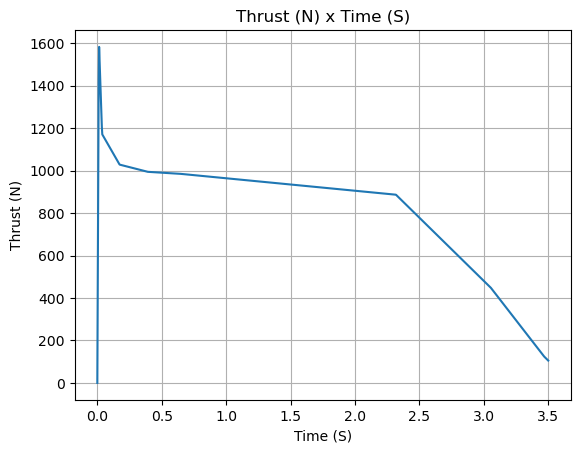

In [9]:
CL805.info()

### Creating a Rocket


A rocket is composed of several components. Namely, we must have a motor, a couple of aerodynamic surfaces (nose cone, fins and tail) and parachutes (if we are not launching a missile).

Let's start by initializing our rocket, named NULI, entering inertia properties, some dimensions and drag curves.

In [10]:
class RocketBody:
    def __init__(self, body_mass, outer_radius, inner_radius, body_height):
        self.body_mass = body_mass  # Mass of the rocket body without motor
        self.outer_radius = outer_radius  # Outer radius of the body
        self.inner_radius = inner_radius  # Inner radius of the body
        self.body_height = body_height  # Height of the rocket body

    def calculate_inertia(self):
        # Calculate moments of inertia for the rocket body (hollow cylinder)
        I11 = I22 = (1 / 12) * self.body_mass * (3 * (self.outer_radius ** 2 + self.inner_radius ** 2) + self.body_height ** 2)
        I33 = (1 / 2) * self.body_mass * (self.outer_radius ** 2 - self.inner_radius ** 2)
        
        return I11, I22, I33

# Example usage:
rocket_body = RocketBody(
    body_mass=11.668,             # Mass of the rocket body without motor, in kg
    outer_radius=0.0635,         # Outer radius of the body, in meters
    inner_radius=0.0615,        # Inner radius of the body, in meters
    body_height=2.55             # Length of the rocket body, in meters
)
body_inertia = rocket_body.calculate_inertia()
print(f"Inertia of Rocket Body (without motor and nose cone): {body_inertia}")

Inertia of Rocket Body (without motor and nose cone): (6.345392396499999, 6.345392396499999, 0.0014585000000000012)


In [11]:
# IMPORTANT: modify the file paths below to match your own system

NULI = Rocket(
    radius=127 / 2000,
    mass=11.668,
    inertia=(6.345392396499999, 6.345392396499999, 0.0014585000000000012),
    power_off_drag="powerOffDragCurve.csv",
    power_on_drag="powerOnDragCurve.csv",
    center_of_mass_without_motor=1.38,
    coordinate_system_orientation="nose_to_tail",
)

# rail_buttons = NULI.set_rail_buttons(
#     upper_button_position=0.0818,
#     lower_button_position=-0.618,
#     angular_position=45,
# )

To add the motor to our rocket we need only inform what motor we are adding (L805) and inform the position, in meters, of the motor's nozzle exit area relative to the previously defined coordinate system.


In [12]:
NULI.add_motor(CL805, position=2.51) # figure out position

#### Adding Aerodynamic Surfaces


Now we define the aerodynamic surfaces. They are really straight forward with special attention needed only for the position values. Here is a quick guide:

- The positions given **must** be relative to the same coordinate system as the rockets;
- Position of the Nosecone refers to the tip of the nose;
- Position of fins refers to the point belonging to the root chord which is highest in the rocket coordinate system;
- Position of the tail the point belonging to the tail which is highest in the rocket coordinate system.

In [13]:
nose_cone = NULI.add_nose(length=0.686, kind="ogive", position=0) # need to update position

fin_set = NULI.add_trapezoidal_fins(
    n=3,
    root_chord=0.152,
    tip_chord=0.102,
    span=0.127,
    position=2.29, # need to update position
    cant_angle=0,
)

To see all information regarding the rocket we just defined we run:



Inertia Details

Rocket Mass: 11.668 kg (without motor)
Rocket Dry Mass: 12.531 kg (with unloaded motor)
Rocket Loaded Mass: 15.037 kg
Rocket Inertia (with unloaded motor) 11: 6.908 kg*m2
Rocket Inertia (with unloaded motor) 22: 6.908 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.001 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.0635 m
Rocket Frontal Area: 0.012668 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.056 m
Rocket Center of Dry Mass - Nozzle Exit: 1.074 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.677 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.113 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 6.590/rad

Center of Pressure

Nose Cone Center of Pressure position: 

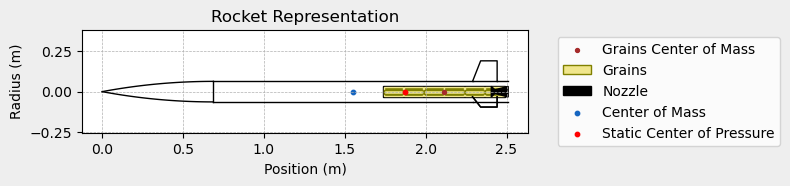


Mass Plots
----------------------------------------


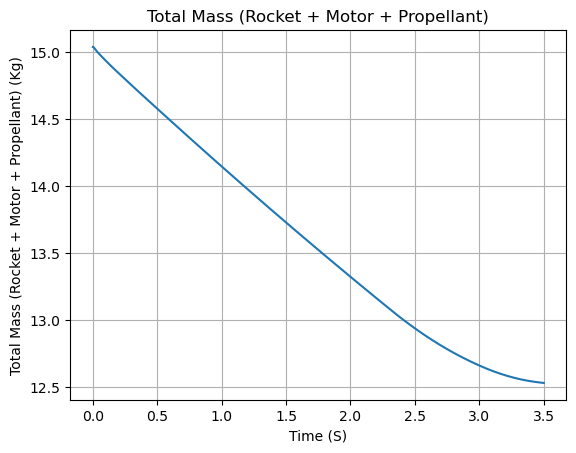

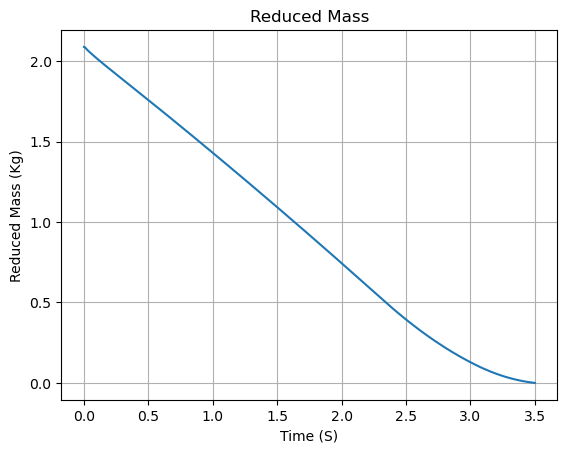


Aerodynamics Plots
----------------------------------------
Drag Plots
--------------------


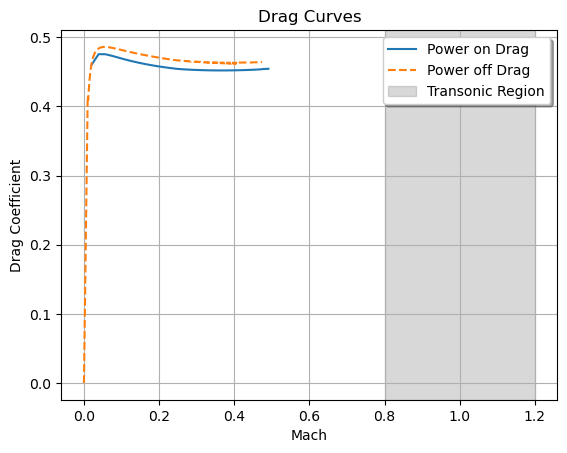


Stability Plots
--------------------


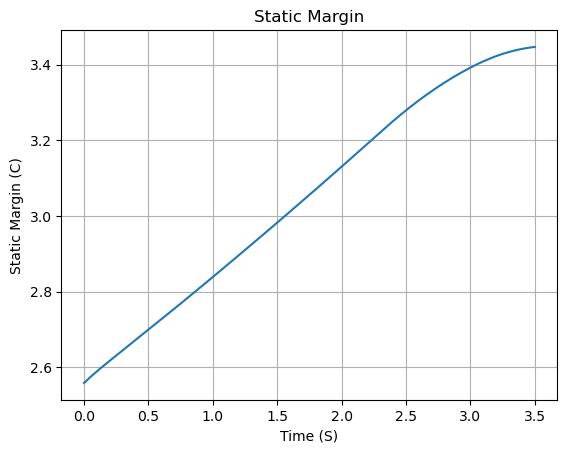

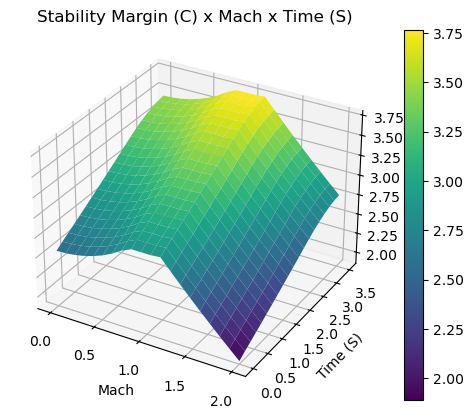


Thrust-to-Weight Plot
----------------------------------------


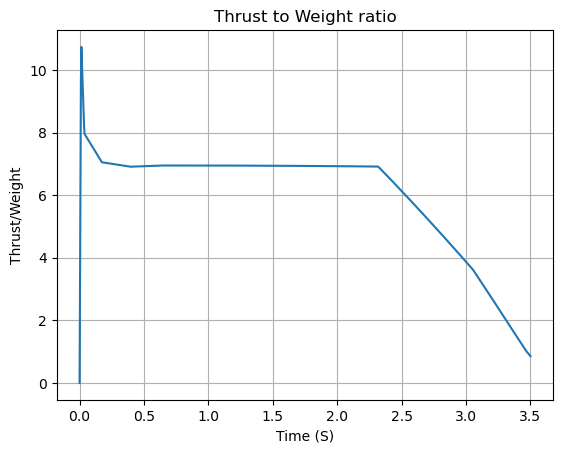

In [14]:
NULI.all_info()

#### Adding Parachutes


Finally, we have parachutes! NULI will have two parachutes, Drogue and Main. The Drogue parachute will open at apogee while the Main parachute will open at 168m above ground level

In [15]:
Main = NULI.add_parachute(
    "Main",
    cd_s=2.2,
    trigger=168,
    sampling_rate=105,
    lag=0,
    noise=(0, 8.3, 0.5),
)

Drogue = NULI.add_parachute(
    "Drogue",
    cd_s=1.5,
    trigger="apogee",
    sampling_rate=105,
    lag=1,
    noise=(0, 8.3, 0.5),
)

Just be careful if you run this last cell multiple times! If you do so, your rocket will end up with lots of parachutes which activate together, which may cause problems during the flight simulation. We advise you to re-run all cells which define our rocket before running this, preventing unwanted old parachutes. Alternatively, you can run the following lines to remove parachutes.

```python
NULI.parachutes.remove(Drogue)
NULI.parachutes.remove(Main)
```


## Simulating a Flight

Simulating a flight trajectory is as simple as initializing a Flight class object givin the rocket and environnement set up above as inputs. The launch rail inclination and heading are also given here.


In [16]:
test_flight = Flight(
    rocket=NULI, environment=env, rail_length=5.2, inclination=88, heading=0
)

## Analyzing the Results

RocketPy gives you many plots. They are divided into sections to keep them organized. Alternatively, see the Flight class documentation to see how to get plots for specific variables only, instead of all of them at once.



Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 1471.47 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 1.000 | e1: -0.017 | e2: 0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -2.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 2.559 c


Surface Wind Conditions

Frontal Surface Wind Speed: 2.03 m/s
Lateral Surface Wind Speed: -1.55 m/s


Launch Rail

Launch Rail Length: 5.2 m
Launch Rail Inclination: 88.00°
Launch Rail Heading: 0.00°


Rail Departure State

Rail Departure Time: 0.405 s
Rail Departure Velocity: 24.866 m/s
Rail Departure Stability Margin: 2.675 c
Rail Departure Angle of Attack: 5.876°
Rail Departure Thrust-Weight Ratio: 6.911
Rail Departure Reynolds Number: 1.887e+05


Burn out State

Burn out time: 3.500 s
Altitude at burn out: 1810.938 m (ASL) | 339.472 m (AGL)
Rocket speed at burn out: 162.993 m/s
Freestream veloci

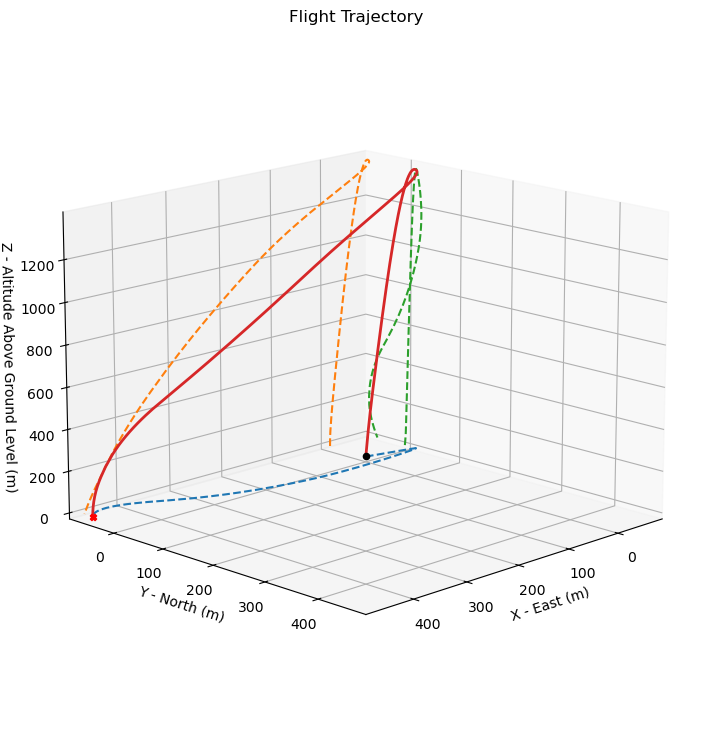



Trajectory Kinematic Plots



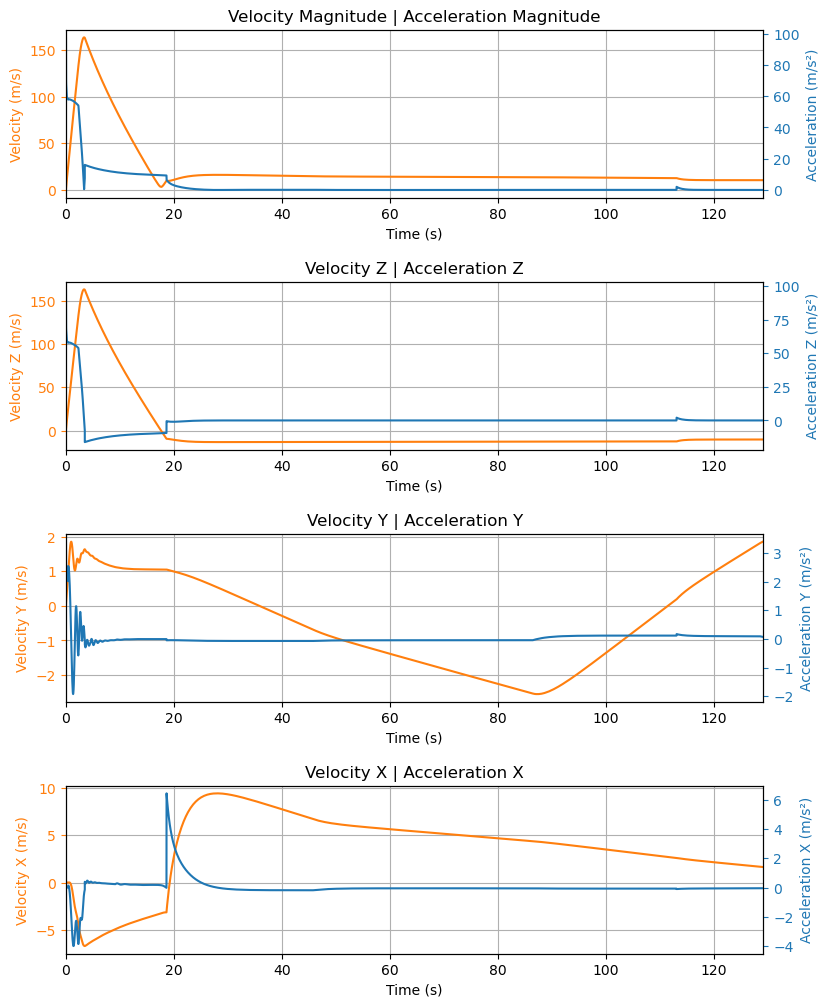



Angular Position Plots



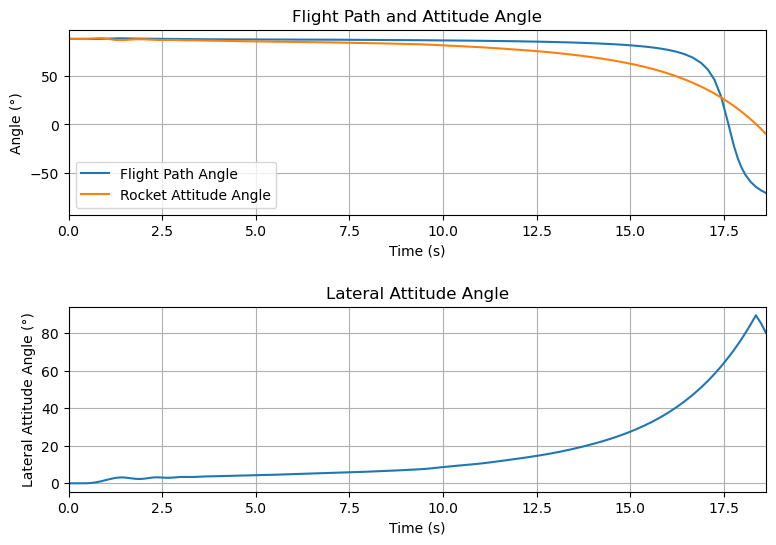



Path, Attitude and Lateral Attitude Angle plots



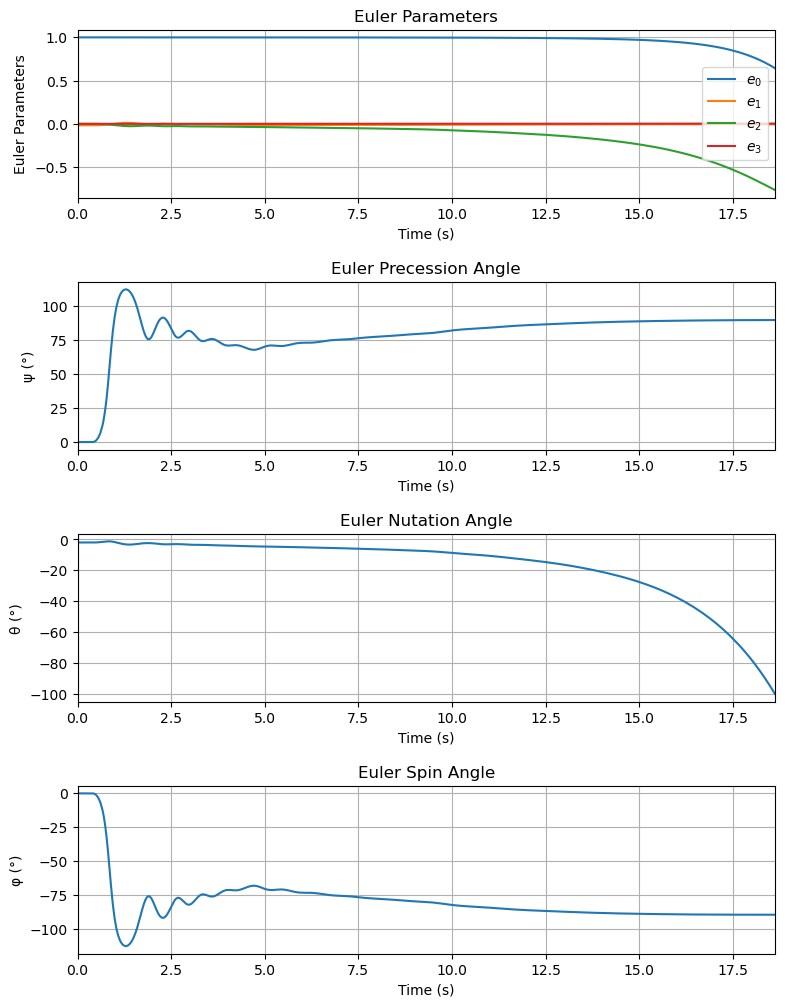



Trajectory Angular Velocity and Acceleration Plots



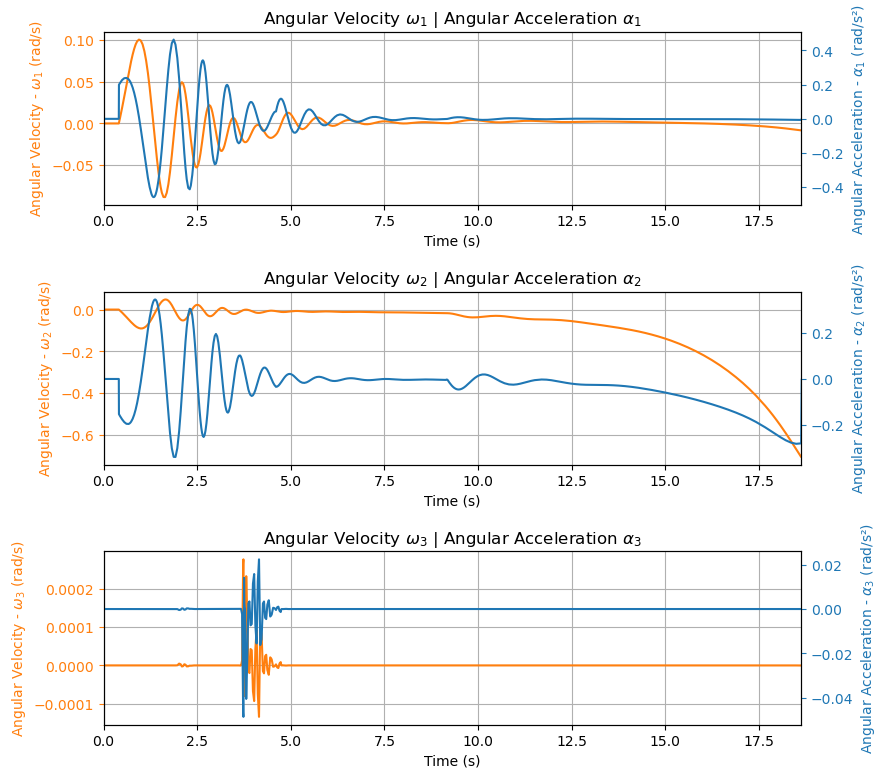



Aerodynamic Forces Plots



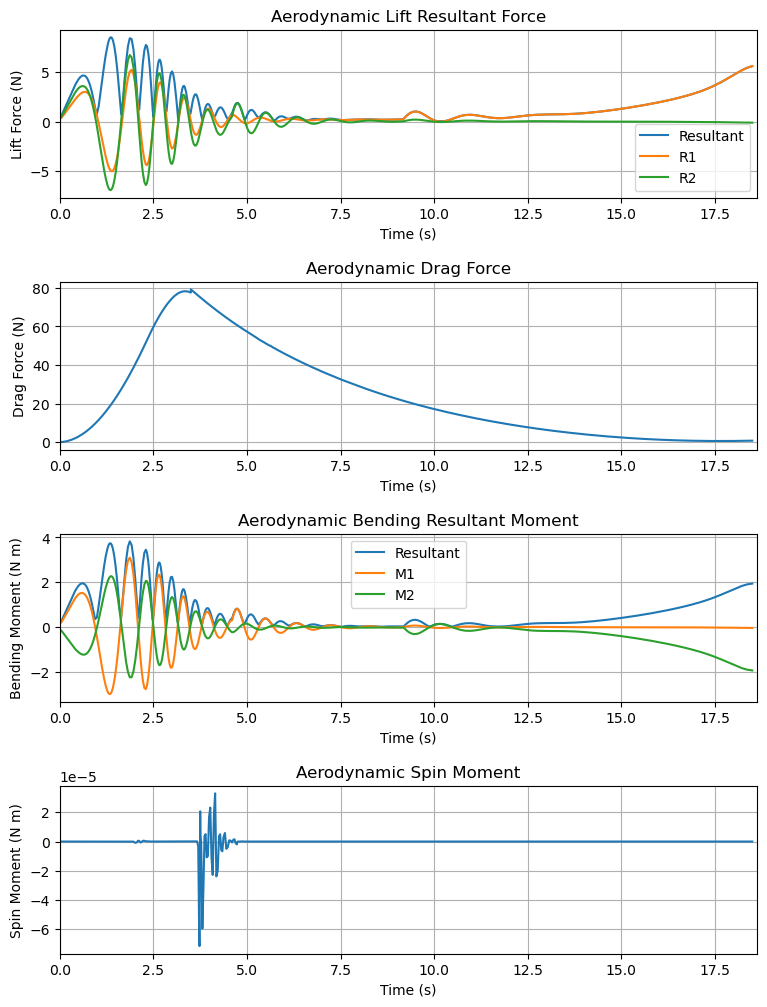



Rail Buttons Forces Plots

No rail buttons were defined. Skipping rail button plots.


Trajectory Energy Plots



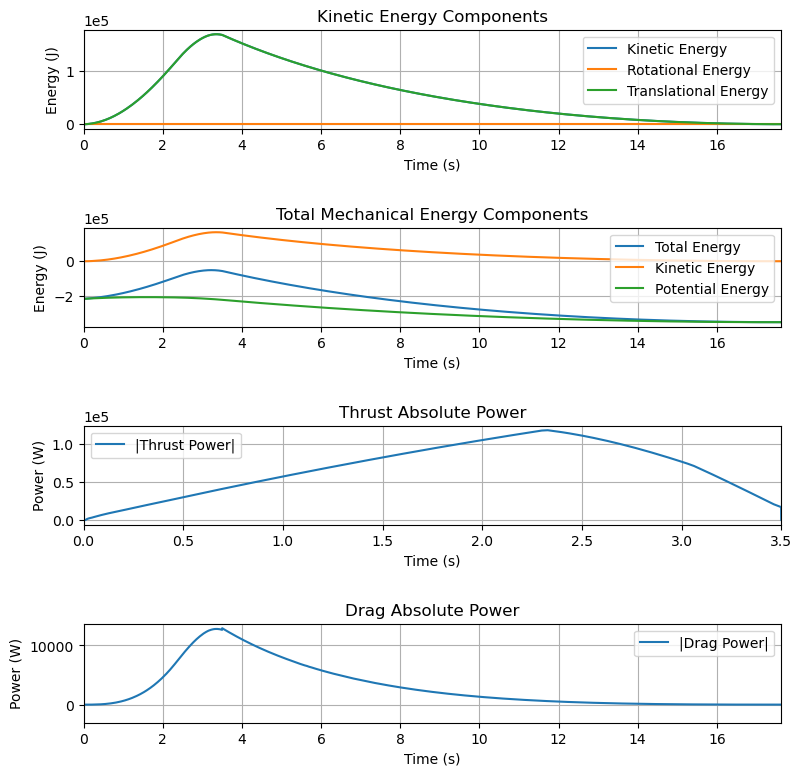



Trajectory Fluid Mechanics Plots



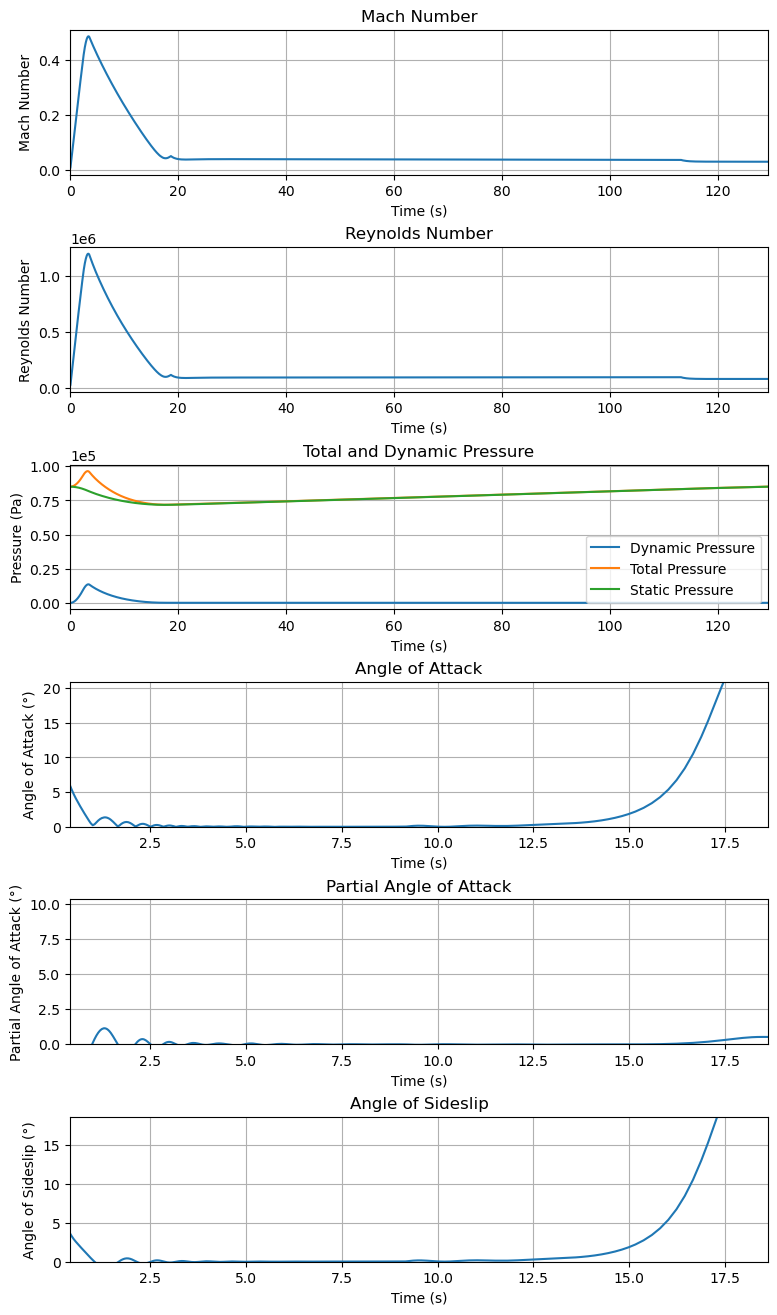



Trajectory Stability and Control Plots



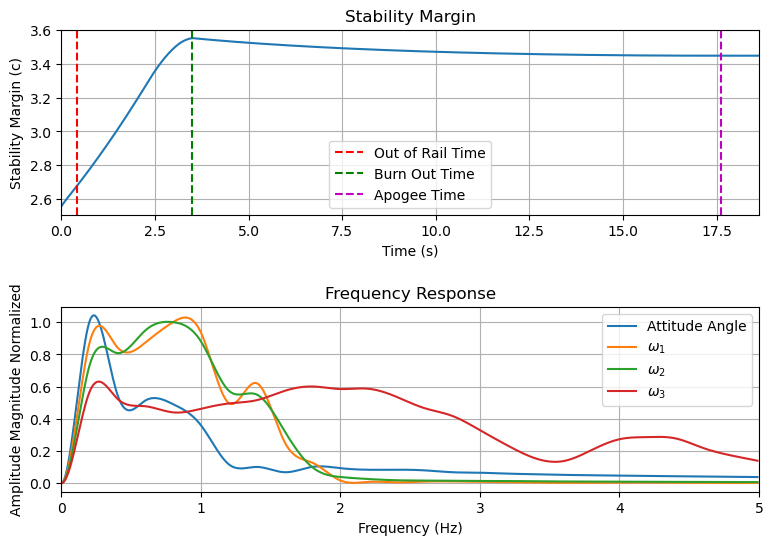



Rocket and Parachute Pressure Plots



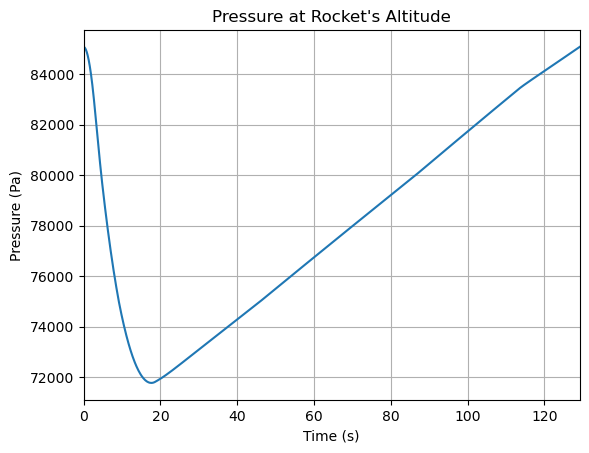


Parachute:  Main


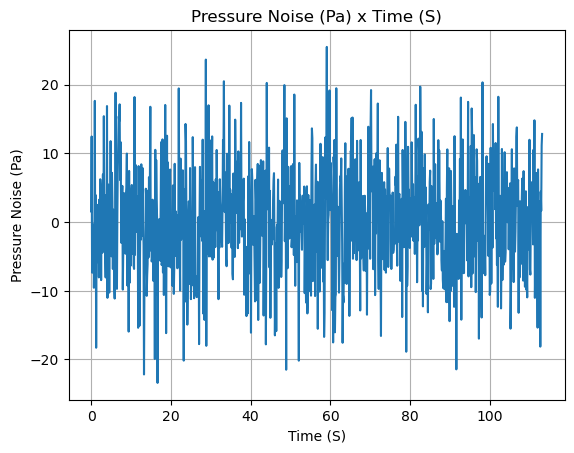

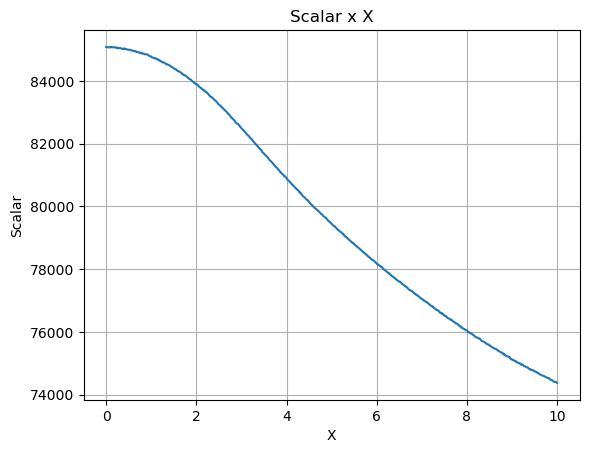

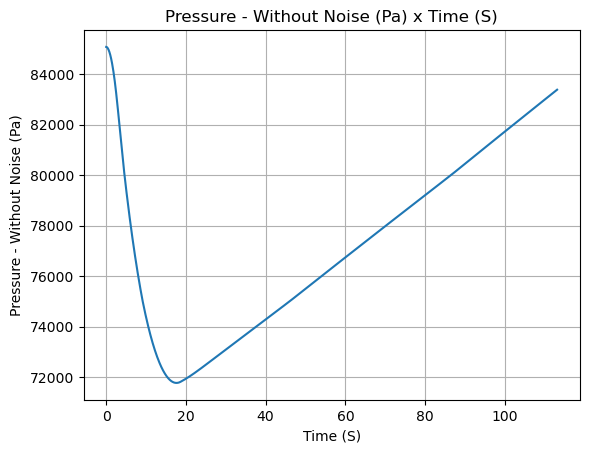


Parachute:  Drogue


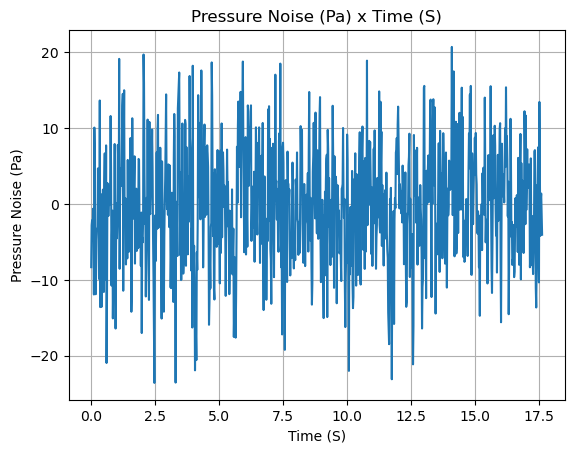

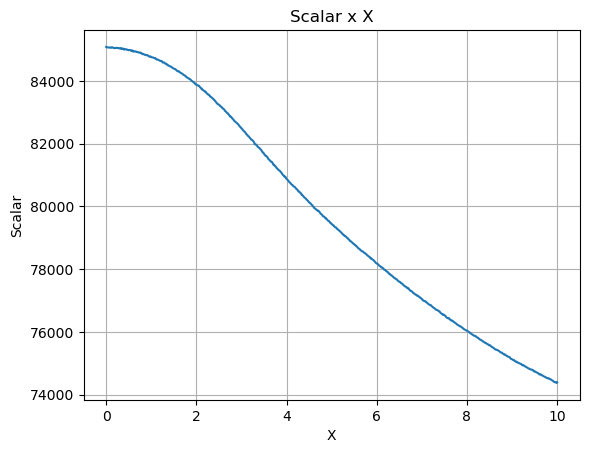

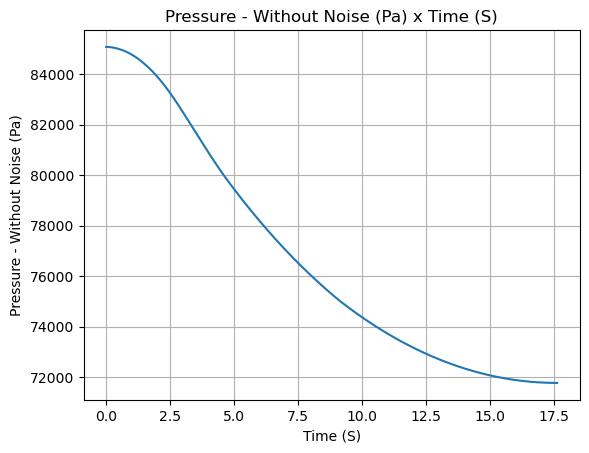

In [17]:
test_flight.all_info()

The flight of the vehicle is graphed to show how far it will drift and the maximum altitude it will reach. The apogee is 4599 ft, which is higher than the OpenRocket simulation but lower than the RASAero II simulation. As described previously, the team will investigate which software simulates apogee the best for the Subscale flight. In addition to the apogee, the drift distance was found to be 1512ft for typical wind conditions at the launch site.

The stability caliber at rail exit is 2.68, which is similar to the other simulated values of calibers. The value of the caliber was graphed for the burn time of the motor, which is 3.5 seconds.

Export Flight Trajectory to a .kml file so it can be opened on Google Earth


In [18]:
test_flight.export_kml(
    file_name="trajectory.kml",
    extrude=True,
    altitude_mode="relative_to_ground",
)

File  trajectory.kml  saved with success!


## Using Simulation for Design

Here, we go through a couple of examples which make use of RocketPy to help us design our rocket.


### Apogee as a Function of Mass

This one is a classic one! We always need to know how much our rocket's apogee will change when our payload gets heavier.


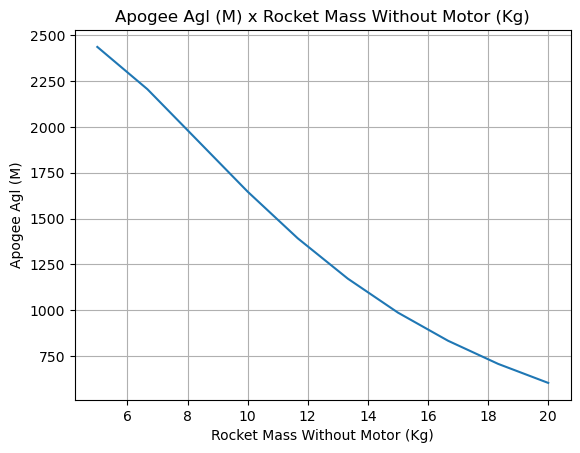

'Function from R1 to R1 : (Rocket Mass without motor (kg)) → (Apogee AGL (m))'

In [19]:
from rocketpy.utilities import apogee_by_mass

apogee_by_mass(flight=test_flight, min_mass=5, max_mass=20, points=10, plot=True)

### Out of Rail Speed as a Function of Mass

Out of rail speed is the speed our rocket has when it is leaving the launch rail. This is crucial to make sure it can fly safely after leaving the rail. A common rule of thumb is that our rocket's out of rail speed should be 4 times the wind speed so that it does not stall and become unstable.


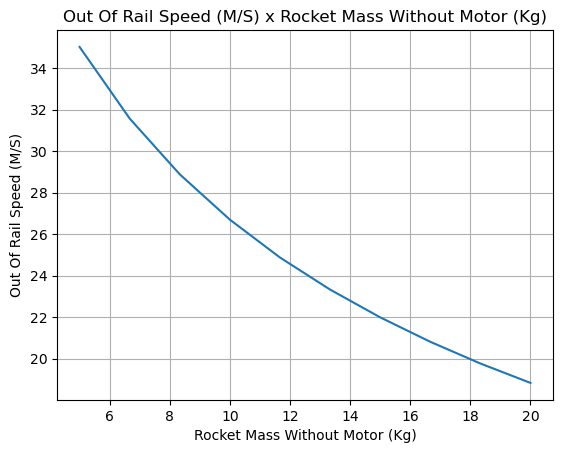

'Function from R1 to R1 : (Rocket Mass without motor (kg)) → (Out of Rail Speed (m/s))'

In [20]:
from rocketpy.utilities import liftoff_speed_by_mass

liftoff_speed_by_mass(flight=test_flight, min_mass=5, max_mass=20, points=10, plot=True)

### Dynamic Stability Analysis

Different static margins result in different dynamic behavior, which also depends on the rocket's rotational inertial.

We used RocketPy's helper class called Function to explore how the dynamic stability of NULI varies if we change the fins span by a certain factor.


Simulating Rocket with Static Margin of -7.731->-7.140 c
Current Simulation Time: 5.0000 s
>>> Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of -9.516->-8.925 c
Current Simulation Time: 5.0000 s
>>> Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of -11.301->-10.711 c
Current Simulation Time: 3.2100 s
>>> Simulation Completed at Time: 3.2012 s
Simulating Rocket with Static Margin of -13.086->-12.496 c
Current Simulation Time: 2.6541 s
>>> Simulation Completed at Time: 2.6537 s
Simulating Rocket with Static Margin of -14.872->-14.281 c
Current Simulation Time: 2.4829 s
>>> Simulation Completed at Time: 2.4742 s


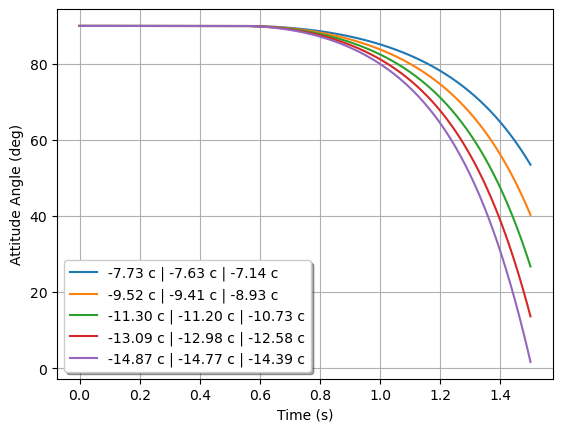

In [21]:
# Helper class
from rocketpy import Function
import copy

# Prepare a copy of the rocket
NULI2 = copy.deepcopy(NULI)

# Prepare Environment Class
custom_env = Environment()
custom_env.set_atmospheric_model(type="custom_atmosphere", wind_v=-5)

# Simulate Different Static Margins by Varying Fin Position
simulation_results = []

for factor in [-0.5, -0.2, 0.1, 0.4, 0.7]:
    # Modify rocket fin set by removing previous one and adding new one
    NULI2.aerodynamic_surfaces.pop(-1)

    fin_set = NULI2.add_trapezoidal_fins(
        n=4,
        root_chord=0.120,
        tip_chord=0.040,
        span=0.100,
        position=-1.04956 * factor,
    )
    # Simulate
    print(
        "Simulating Rocket with Static Margin of {:1.3f}->{:1.3f} c".format(
            NULI2.static_margin(0),
            NULI2.static_margin(NULI2.motor.burn_out_time),
        )
    )
    test_flight = Flight(
        rocket=NULI2,
        environment=custom_env,
        rail_length=5.2,
        inclination=90,
        heading=0,
        max_time_step=0.01,
        max_time=5,
        terminate_on_apogee=True,
        verbose=True,
    )
    # Store Results
    static_margin_at_ignition = NULI2.static_margin(0)
    static_margin_at_out_of_rail = NULI2.static_margin(test_flight.out_of_rail_time)
    static_margin_at_steady_state = NULI2.static_margin(test_flight.t_final)
    simulation_results += [
        (
            test_flight.attitude_angle,
            "{:1.2f} c | {:1.2f} c | {:1.2f} c".format(
                static_margin_at_ignition,
                static_margin_at_out_of_rail,
                static_margin_at_steady_state,
            ),
        )
    ]

Function.compare_plots(
    simulation_results,
    lower=0,
    upper=1.5,
    xlabel="Time (s)",
    ylabel="Attitude Angle (deg)",
)

### Characteristic Frequency Calculation

Here we analyze the characteristic frequency of oscillation of our rocket just as it leaves the launch rail. Note that when we ran test_flight.all_info(), one of the plots already showed us the frequency spectrum of our flight. Here, however, we have more control of what we are plotting.


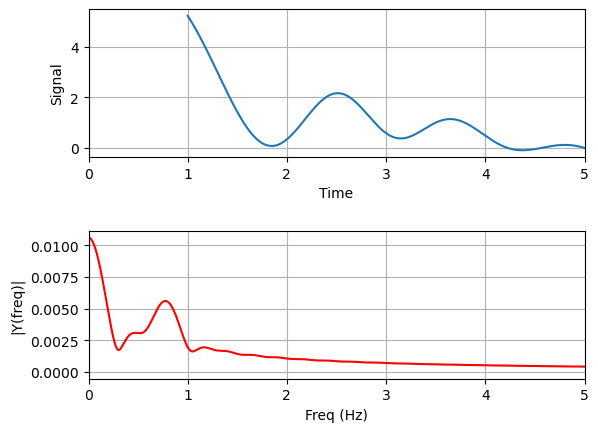

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate first 5 seconds of Flight
flight = Flight(
    rocket=NULI,
    environment=env,
    rail_length=5.2,
    inclination=90,
    heading=0,
    max_time_step=0.01,
    max_time=5,
)

# Perform a Fourier Analysis
Fs = 100.0
# sampling rate
Ts = 1.0 / Fs
# sampling interval
t = np.arange(1, 400, Ts)  # time vector
ff = 5
# frequency of the signal
y = flight.attitude_angle(t) - np.mean(flight.attitude_angle(t))
n = len(y)  # length of the signal
k = np.arange(n)
T = n / Fs
frq = k / T  # two sides frequency range
frq = frq[range(n // 2)]  # one side frequency range
Y = np.fft.fft(y) / n  # fft computing and normalization
Y = Y[range(n // 2)]

# Create the plot
fig, ax = plt.subplots(2, 1)
ax[0].plot(t, y)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Signal")
ax[0].set_xlim((0, 5))
ax[0].grid()
ax[1].plot(frq, abs(Y), "r")  # plotting the spectrum
ax[1].set_xlabel("Freq (Hz)")
ax[1].set_ylabel("|Y(freq)|")
ax[1].set_xlim((0, 5))
ax[1].grid()
plt.subplots_adjust(hspace=0.5)
plt.show()